# Replicating the Paper
 

- Building off of Nicks work in $\texttt{Implementation.ipynb}$ this notebook trys to follow as closely as possible the paper's methods.
- I tried to label as many areas as I could where we could improve or use something better.
- I start with the cleaned data that Nick prepared.
## Contents
- [Read Data](#first-bullet)
- [Correlation Matrix](#second-bullet)
- [Eigenspectra](#third-bullet)
- [Cluster Structure](#fourth-bullet)
    - Threshold method
    - Spectral clustering
- [Minimal Spanning Trees](#fifth-bullet)

## Read Data

In [318]:
import pandas as pd
import numpy as np
import sklearn as sk
import random
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import islice
from sklearn.cluster import SpectralClustering

exch_dat = pd.read_csv('../data/cleaned_paper_data.csv')
exch_dat.index = exch_dat['YYYY/MM/DD']
exch_dat = exch_dat.drop(['Unnamed: 0','YYYY/MM/DD'], axis=1)

In [189]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Correlation Matrix

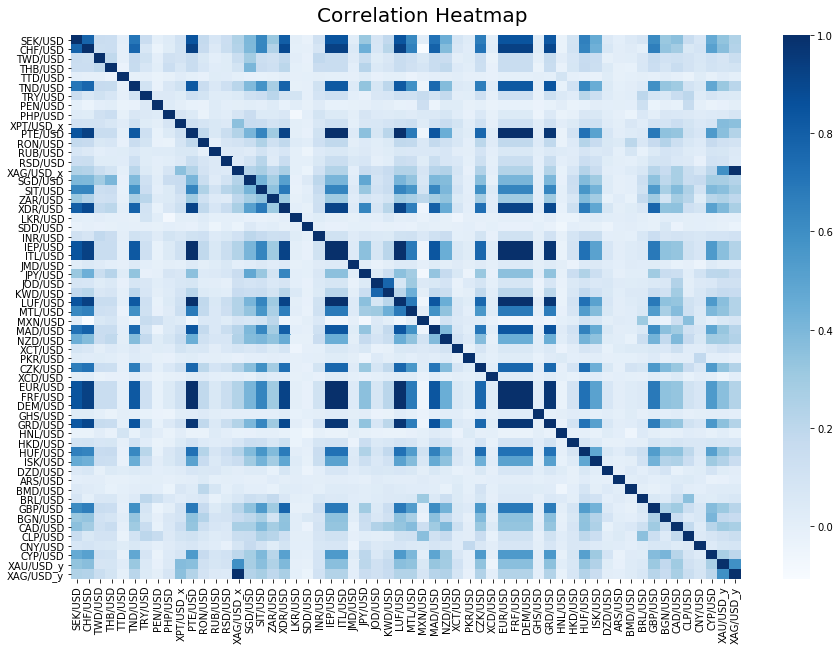

In [94]:
exch_logrets = np.log(exch_dat) - np.log(exch_dat.shift(1))
exch_logrets = exch_logrets.iloc[1:,:]
C = exch_logrets.corr()  # only for x/USD
C[C.isna()] = 0  # still some NAs in data

# Heatmap of Corr
fig, ax = plt.subplots(figsize=(15, 10))
fig.suptitle("Correlation Heatmap", fontsize=20, x=.45, y=.92)
sns.heatmap(C, cmap="Blues", xticklabels=C.columns, yticklabels=C.columns);

## Eigenspectra

In [77]:
eigvals, eigvecs = np.linalg.eig(C)
eigvals.sort()

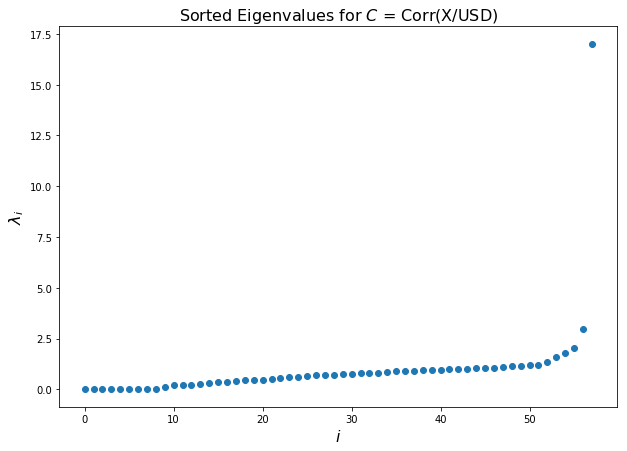

In [92]:
plt.figure(figsize=(10, 7))
plt.scatter(y=eigvals, x=range(0, len(eigvals)))
plt.title('Sorted Eigenvalues for $C$ = Corr(X/USD)', fontsize=16)
plt.xlabel('$i$', fontsize=16)
plt.ylabel('$\lambda_i$', fontsize=16)
plt.show();

This agrees with what the paper has for USD at least. Most all of the eigenvalues are really close to zero. This is just showing that USD is a very interconnected currency. We would expect other base currency correlation matrices to have bigger eigenvalues.

The paper then also finds the residuals of the regression,

$$
G_X^B(t) = \beta G_Y^B(t) + \alpha + \epsilon_X^B(t), \quad i = 1,...,N-1
$$

in order to reduce the influence of USD and EUR on all the other base currency networks. I think we would need to do this with BTC when we move to cryptocurrencies. In our current data we only have x/USD so there is no need to do this. 

## Cluster Structure 
In the paper all they do is find some threshold $p_c$ and zero-out all entries in $C$ that are not greater than it. They do this for many $p_c$'s to find ones that give reasonable clusters based on geography or economic reasoning. This seems pretty weird to me and I think this would be a great time to add in spectral clustering. I will start with their method just for completeness though.
#### Thresholding $C$ Method (bad)

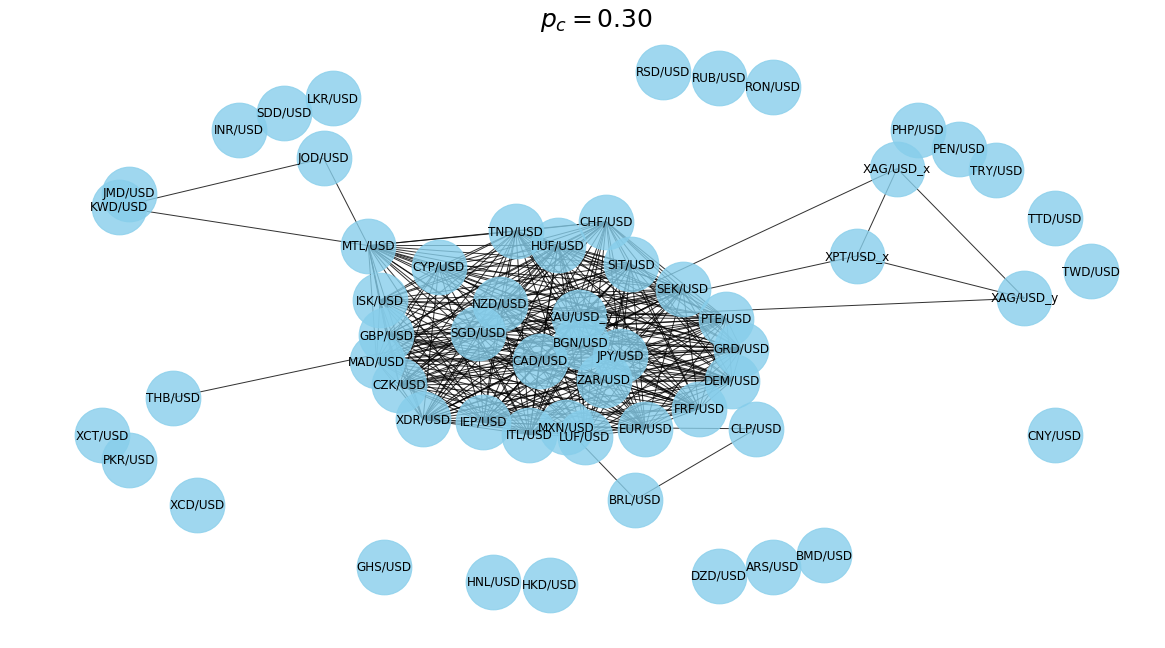

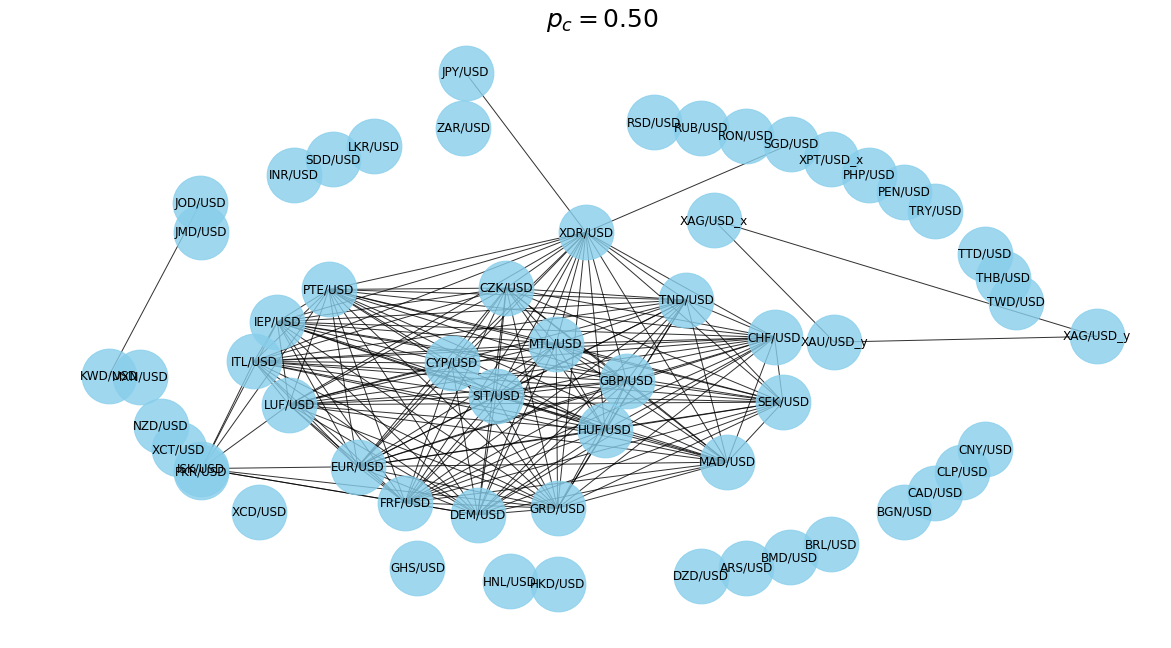

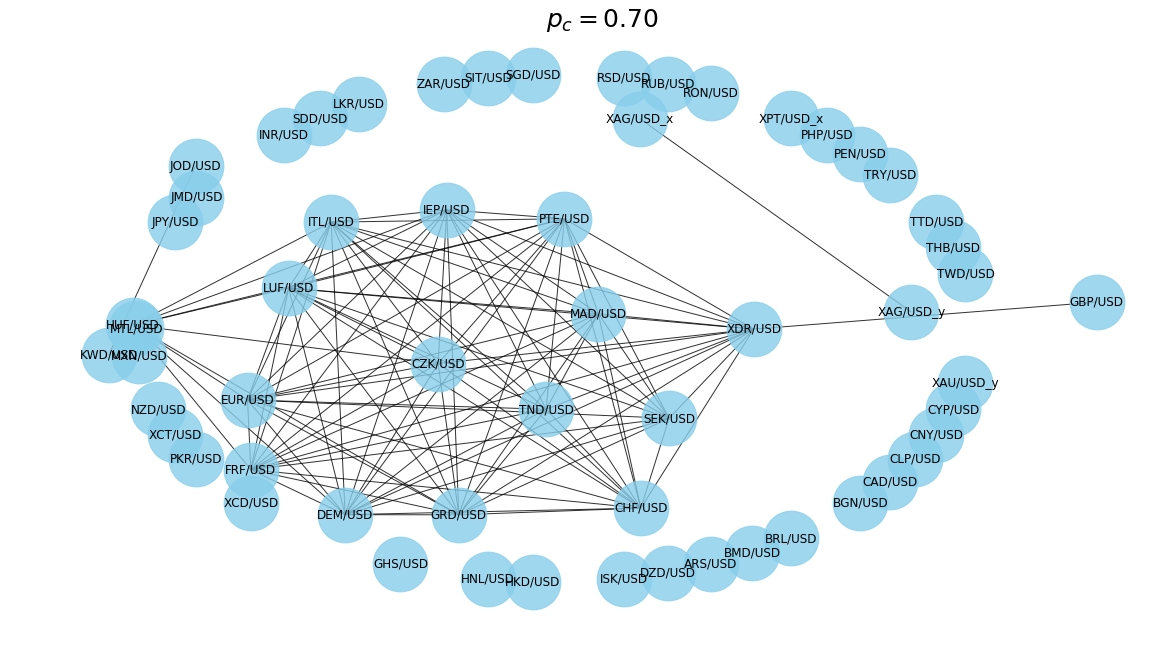

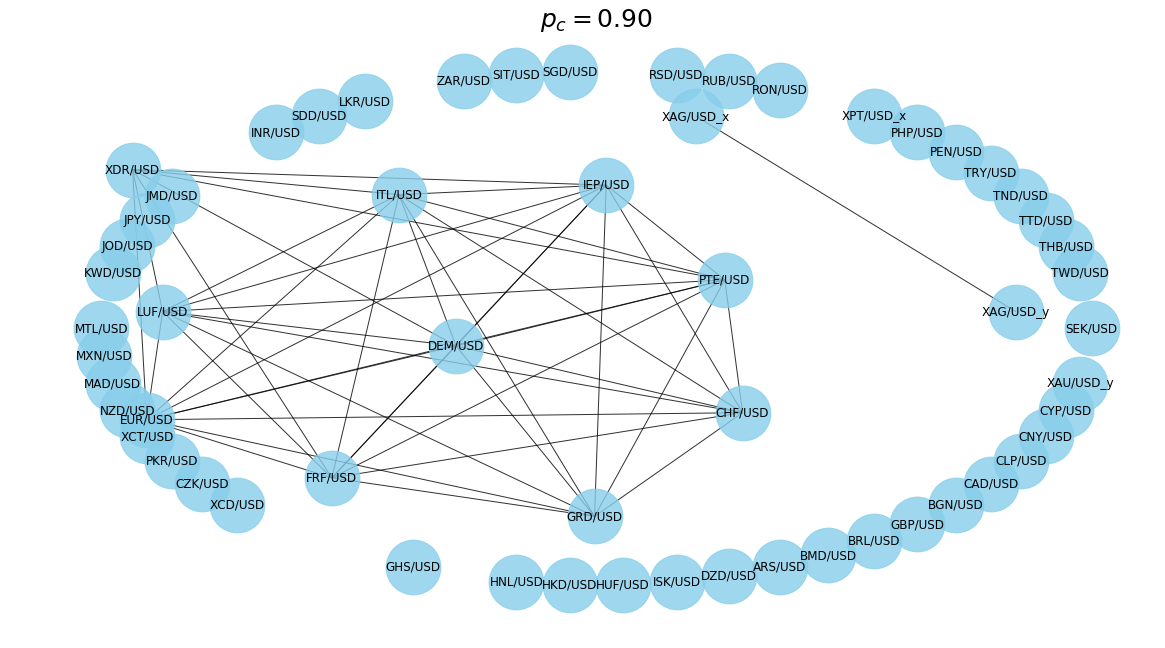

In [221]:
pcs = range(3, 10, 2)  # range parameter will take divided by 10

C_thresh = C.copy()  # copy it so we can alter it
labels = {}
for j in range(len(C_thresh.columns)):
    labels[j] = C_thresh.columns[j]


ttl = "Networks as $p_c$ ranges in [0.30, 0.90]"
fig.suptitle(ttl)
for plot_i, thresh_i in zip(range(len(pcs)), [x / 10 for x in pcs]):
    C_thresh = C.copy()  # copy it so we can alter it
    C_thresh[C_thresh < thresh_i] = 0
    C_thresh -= np.identity(C_thresh.shape[0])
    C_thresh = np.array(C_thresh)
    fig = plt.figure(figsize=(20, 50))
    fig.add_subplot(len(pcs), 1, plot_i + 1)
    
    G = nx.Graph(C_thresh)
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, with_labels=False, node_size=3000, 
        node_color="skyblue", node_shape="o", 
        alpha=0.8, pos=pos)
    nx.draw_networkx_labels(G,pos,labels)
    plt.title('$p_c=$' + str(thresh_i) + "0", fontsize=25)
    plt.show()


You can see that as $p_c$ increases the periphery has more and more vertices in its membership, there are more nodes that are not connected to anything. To me this method doesn't really make a lot of sense for clustering. It seems to be a pretty coarse way of determining "like" groups of rates. I think spectral clustering might do better and that is what I try next.

#### Spectral Clustering  <span style="color:red">NEEDS TO BE FINISHED</span>
I think the paper $\texttt{docs/spectral_clustering_using_canonical_correlation.pdf}$ is a good way to do this that could be cool. At first I just used the $D$ distance matrix they used in the paper and threw it into $\texttt{sklearn.cluster.SpectralClustering}$ without much thought.

In [ ]:
# First Pass at Spectral Clustering
C = exch_logrets.corr()  # only for x/USD
C[C.isna()] = 0  # still some NAs in data
D = np.sqrt(2 * (1 - C))

sc_mod = SpectralClustering(n_clusters=20, gamma=1.0, 
                   affinity='precomputed', assign_labels='kmeans')
clusters = sc_mod.fit_predict(D)


G = nx.draw_networkx_nodes(D)
pos = nx.kamada_kawai_layout(G)
    
for jclust in list(np.unique(clusters)):
    
    G = nx.Graph(D[bools])
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, with_labels=False, node_size=3000, 
        node_color="skyblue", node_shape="o", 
        alpha=0.8, pos=pos)
    nx.draw_networkx_labels(G,pos,labels)
    plt.title('$p_c=$' + str(thresh_i) + "0", fontsize=25)
plt.show()

In [ ]:
C = exch_logrets.corr()  # only for x/USD
C[C.isna()] = 0  # still some NAs in data
D = np.sqrt(2 * (1 - C))

sc_mod = SpectralClustering(n_clusters=20, gamma=1.0, 
                   affinity='precomputed', assign_labels='kmeans')
clusters = sc_mod.fit_predict(D)

fig = plt.figure(figsize=(20, 12))

G = nx.Graph(D)

C=nx.connected_component_subgraphs(G)
for g in C:
    c=[random.random()]*nx.number_of_nodes(g) # random color...
    nx.draw(g,
         pos,
         node_size=40,
         node_color=c,
         vmin=0.0,
         vmax=1.0,
         with_labels=False
         )

In [ ]:
def makeClustAdj(clusters):
    uniq_clusters = np.unique(clusters)
    nClust = len(uniq_clusters)
    mat = 1 - np.diag(np.sum(clusters == uniq_clusters[0]))
    if nClust > 1:
        for nc in range(2, nClust):
            mat_temp = 1 - np.diag()

## Minimal Spanning Tree (MST)

They use MST in the paper for nothing other than making a graph easy to visualize and be interpretable. It doesn't give you antyhing besides telling you that for each node what is the closest node to it in distance. They define the distances as,

$$
d_{X,Y}^B = \sqrt{2(1 - C_{X,Y}^B)}.
$$

They also show the $\lambda_1$ for various bases over time (with a 6 month rolling window). We only have USD as a base so I just show that.

In [325]:
def window(seq, n=20*6):
    # 20 * 6 trading days in 6 months roughly
    # Returns a sliding window (of width n) over data from the iterable
    #   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...  
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

eigs_ovr_time = []
start_time = []
for jwind in window(exch_logrets.index):
    bools = np.logical_and(exch_logrets.index >= jwind[0], 
                           exch_logrets.index <= jwind[len(jwind)-1])
    C_temp = exch_logrets[bools].corr() 
    C_temp[C_temp.isna()] = 0  # still some NAs in data
    eigvals_temp, eigvecs_temp = np.linalg.eig(C_temp)
    eigvals_temp.sort()
    eigs_ovr_time.append(eigvals_temp[0])
    start_time.append(jwind[0])

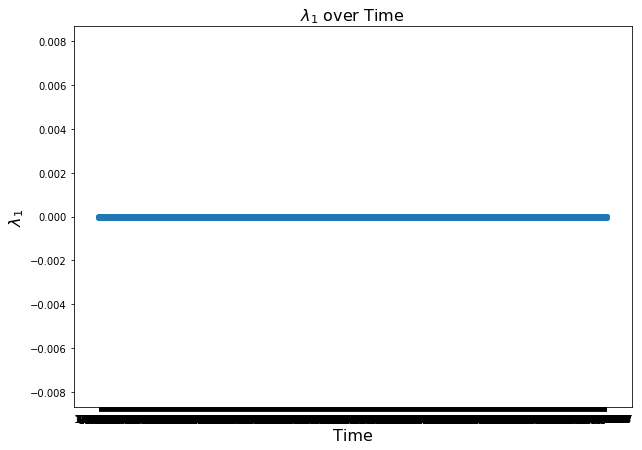

In [326]:
# Plot Eig 1 over Time
plt.figure(figsize=(10, 7))
plt.scatter(y=eigs_ovr_time, x=start_time)
plt.title('$\lambda_1$ over Time', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.ylabel('$\lambda_1$', fontsize=16)
plt.show();

I cannot seem to get Eigevalues above very very small values, mine are somwhere near 5E^-16. In the paper it seems like they are getting values much higher and variable over time. This is slightly confusing because in the earlier section of their paper the $\lambda_1$'s for USD based $X$. Were very small like mine. Perhaps I didn't read carefully enough and they made some transform so that plotting would be easier. I need to look at this further.


They show the MST for disparate time periods, 01/1999-12/2001 (Interval 1) and 07/2005-06/2008 (Interval 2). I'll do a similar thing and we can see how they change.

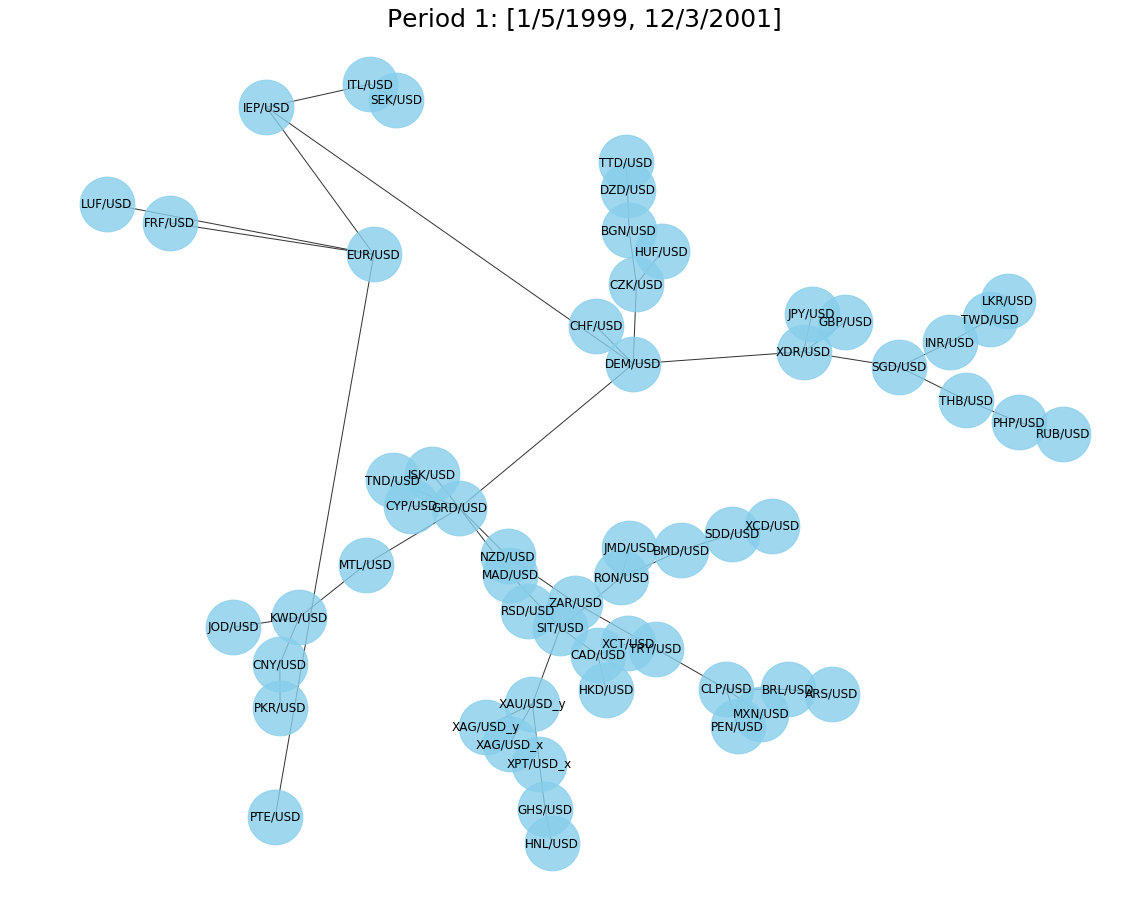

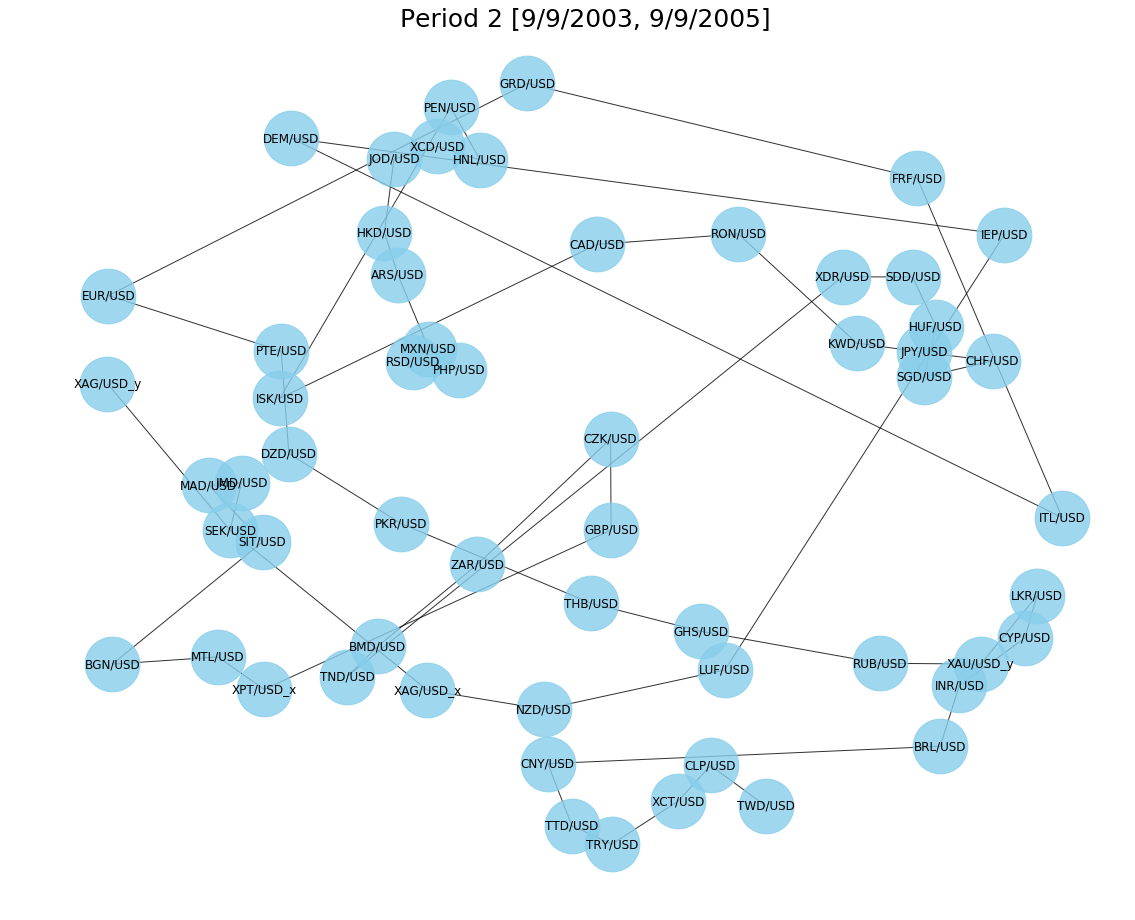

In [256]:
# Decide on two periods
start1 = '1/5/1999'
end1   = '12/3/2001'
start2 = '9/9/2003'
end2   = '9/9/2005'

# Period 1 Graph
bool1 = np.logical_and(exch_logrets.index >= start1, exch_logrets.index <= end1)
C = exch_logrets[bool1].corr()  # only for x/USD
C[C.isna()] = 0  # still some NAs in data

D = np.sqrt(2 * (1 - C))
MST = minimum_spanning_tree(D) # cst object. NOT a distance matrix.
MST_matrix = MST.toarray()

labels={}
for j in range(len(D.columns)):
    labels[j] = D.columns[j]
    
fig = plt.figure(figsize=(15, 12))
G = nx.Graph(MST_matrix)
pos = nx.fruchterman_reingold_layout(G)
nx.draw(G, with_labels=False, node_size=3000, 
        node_color="skyblue", node_shape="o", 
        alpha=0.8, pos=pos)
nx.draw_networkx_labels(G,pos,labels)
plt.title("Period 1: [" + str(start1) + ", " + str(end1) + "]" ,
         fontsize=25)
plt.show()

# Period 2 Graph
bool2 = np.logical_and(exch_logrets.index >= start2, exch_logrets.index <= end2)
C = exch_logrets[bool2].corr()  # only for x/USD
C[C.isna()] = 0  # still some NAs in data

D = np.sqrt(2 * (1 - C))
MST = minimum_spanning_tree(D) # cst object. NOT a distance matrix.
MST_matrix = MST.toarray()

labels={}
for j in range(len(D.columns)):
    labels[j] = D.columns[j]
    
fig = plt.figure(figsize=(15, 12))
G = nx.Graph(MST_matrix)
pos = nx.fruchterman_reingold_layout(G)
nx.draw(G, with_labels=False, node_size=3000, 
        node_color="skyblue", node_shape="o", 
        alpha=0.8, pos=pos)
nx.draw_networkx_labels(G,pos,labels)
plt.title("Period 2 [" + str(start2) + ", " + str(end2) + "]" ,
         fontsize=25)
plt.show()